In [81]:
print('ACIT 4620')
print('\nGroup-6')
print('\nparticipate: Julie Hallen, Brage Ramberg, Alexander bazo, Daniel Bjordal, , Harith Elamin')

ACIT 4620

Group-6

participate: Julie Hallen, Brage Ramberg, Alexander bazo, Daniel Bjordal, , Harith Elamin


In [6]:
print('Tools and Libraries:')
print('\n1- Python 3.')
print('\n2- scikit-fuzzy for fuzzy logic and fuzzy systems')
print('\n3- networkx for the creation, manipulation')
print('\n4- NumPy for numerical computations.')
print('\n5- pandas for data manipulation and analysis.')
print('\n6- requests for the process of sending and receiving data from websites.')
print('\n7- Matplotlib for plotting results.')
print('\n8-Keras for the convenience of mathematical calculations')


Tools and Libraries:

1- Python 3.

2- scikit-fuzzy for fuzzy logic and fuzzy systems

3- networkx for the creation, manipulation

4- NumPy for numerical computations.

5- pandas for data manipulation and analysis.

6- requests for the process of sending and receiving data from websites.

7- Matplotlib for plotting results.

8-Keras for the convenience of mathematical calculations


In [302]:
!pip3 freeze
!pip3 install pandas scikit-fuzzy -U scikit-learn networkx numpy tensorflow keras matplotlib requests pandas seaborn

^C
about-time==4.2.1
alive-progress==3.1.5
asttokens==2.4.1
autograd==1.7.0
beautifulsoup4==4.12.3
certifi==2024.8.30
charset-normalizer==3.4.0
cloudpickle==3.1.0
cma==3.2.2
colorama==0.4.6
comm==0.2.2
contourpy==1.3.0
cycler==0.12.1
deap==1.4.1
debugpy==1.8.7
decorator==5.1.1
Deprecated==1.2.14
dill==0.3.9
executing==2.1.0
Farama-Notifications==0.0.4
fonttools==4.54.1
frozendict==2.4.6
grapheme==0.6.0
gym==0.26.2
gym-notices==0.0.8
gymnasium==1.0.0
html5lib==1.1
idna==3.10
ipykernel==6.29.5
ipython==8.28.0
jedi==0.19.1
joblib==1.4.2
jupyter_client==8.6.3
jupyter_core==5.7.2
kiwisolver==1.4.7
lxml==5.3.0
matplotlib==3.9.2
matplotlib-inline==0.1.7
multitasking==0.0.11
nest-asyncio==1.6.0
networkx==3.4.2
numpy==2.1.3
packaging==24.1
pandas==2.2.3
parso==0.8.4
peewee==3.17.7
pillow==11.0.0
platformdirs==4.3.6
prompt_toolkit==3.0.48
psutil==6.1.0
pure_eval==0.2.3
Pygments==2.18.0
pymoo==0.6.1.3
pyparsing==3.2.0
python-dateutil==2.9.0.post0
pytz==2024.2
pywin32==308
pyzmq==26.2.0
requests==

ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11; 1.26.0 Requires-Python <3.13,>=3.9; 1.26.1 Requires-Python <3.13,>=3.9
ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.model_selection import train_test_split

In [127]:
import sys
print('System version',sys.version)

System version 3.13.0 (tags/v3.13.0:60403a5, Oct  7 2024, 09:38:07) [MSC v.1941 64 bit (AMD64)]


Project Proposal:

Datasets:

Employment history feature: 
https://www.kaggle.com/competitions/playground-series-s4e10/data?select=train.csv&fbclid=IwZXh0bgNhZW0CMTEAAR3m8MTqUNOmYlHeO4aSG3t27BQAZmFUhklp47HlrgQKs-a_jqKvER8MLxI_aem_wnn0vq8GNdEFy5I6HQg8XA

Credit score dataset feature: 
https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset?fbclid=IwZXh0bgNhZW0CMTEAAR3qB690tKMRmu3WPfOR3JX_uWnwWm5UZ8egilKtbPSOXpd80po5694E-Ew_aem_y6J4ieYEDtECW1CeA750dQ

In [163]:
# Read the CSV file
data = pd.read_csv('../ACIT4620-24H-G6/dataset/loan_dataset.csv')

In [164]:
# Print the columns
print(data.columns)

Index(['Applicant_ID', 'Gender', 'Age', 'Marital_Status', 'Dependents',
       'Education', 'Employment_Status', 'Occupation_Type',
       'Residential_Status', 'City/Town', 'Annual_Income', 'Monthly_Expenses',
       'Credit_Score', 'Existing_Loans', 'Total_Existing_Loan_Amount',
       'Outstanding_Debt', 'Loan_History', 'Loan_Amount_Requested',
       'Loan_Term', 'Loan_Purpose', 'Interest_Rate', 'Loan_Type',
       'Co-Applicant', 'Bank_Account_History', 'Transaction_Frequency',
       'Default_Risk', 'Loan_Approval_Status'],
      dtype='object')


In [165]:
# Print dataset colums
data.head(100)

,Applicant_ID,Gender,Age,Marital_Status,Dependents,Education,Employment_Status,Occupation_Type,Residential_Status,City/Town,...,Loan_Amount_Requested,Loan_Term,Loan_Purpose,Interest_Rate,Loan_Type,Co-Applicant,Bank_Account_History,Transaction_Frequency,Default_Risk,Loan_Approval_Status
0,1,Female,25,Married,2,Graduate,Employed,Business,Own,Urban,...,24535,209,Home,4.27,Secured,Yes,8,20,0.81,1
1,2,Male,36,Married,2,High School,Employed,Business,Own,Suburban,...,8288,33,Home,14.78,Unsecured,Yes,9,9,0.17,0
2,3,Male,43,Single,0,Postgraduate,Self-Employed,Freelancer,Own,Urban,...,10308,159,Vehicle,12.33,Secured,Yes,7,27,0.25,0
3,4,Female,28,Married,0,High School,Self-Employed,Freelancer,Rent,Suburban,...,33937,39,Personal,8.77,Secured,No,9,16,0.27,1
4,5,Female,32,Single,0,Graduate,Employed,Salaried,Rent,Suburban,...,23360,34,Home,9.04,Unsecured,No,1,17,0.32,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,Female,37,Married,0,High School,Self-Employed,Professional,Own,Rural,...,21760,121,Home,8.97,Secured,Yes,5,29,0.97,1
96,97,Male,26,Single,2,Graduate,Unemployed,Professional,Own,Suburban,...,20000,177,Vehicle,9.74,Secured,Yes,0,16,0.94,1
97,98,Female,49,Divorced,0,High School,Employed,Business,Rent,Suburban,...,22702,108,Vehicle,10.40,Secured,No,6,10,0.59,1
98,99,Female,36,Single,1,Postgraduate,Self-Employed,Business,Own,Suburban,...,21339,23,Education,9.19,Unsecured,No,0,6,0.25,1


In [206]:
print(data.columns)

Index(['Applicant_ID', 'Gender', 'Age', 'Marital_Status', 'Dependents',
       'Education', 'Employment_Status', 'Occupation_Type',
       'Residential_Status', 'City/Town', 'Annual_Income', 'Monthly_Expenses',
       'Credit_Score', 'Existing_Loans', 'Total_Existing_Loan_Amount',
       'Outstanding_Debt', 'Loan_History', 'Loan_Amount_Requested',
       'Loan_Term', 'Loan_Purpose', 'Interest_Rate', 'Loan_Type',
       'Co-Applicant', 'Bank_Account_History', 'Transaction_Frequency',
       'Default_Risk', 'Loan_Approval_Status'],
      dtype='object')


In [259]:
# Define fuzzy variables (input variables)
# We selected the most important columns from the dataset to use later in the rules.
selected_columns = ['Employment_Status', 'Annual_Income', 'Credit_Score', 'Outstanding_Debt', 'Loan_Amount_Requested', 'Loan_Type','Loan_Purpose', 'Loan_Approval_Status']

Employment_Status = ctrl.Antecedent(np.arange(18, 101, 1), 'Employment_Status')
Annual_Income = ctrl.Antecedent(np.arange(0, 500000, 1000), 'Annual_Income')
Credit_Score = ctrl.Antecedent(np.arange(1000, 50000, 500), 'Credit_Score')
Outstanding_Debt = ctrl.Antecedent(np.arange(0, 30, 0.1), 'Outstanding_Debt')
Loan_Amount_Requested = ctrl.Antecedent(np.arange(0, 1, 0.01), 'Loan_Amount_Requested')
Loan_Type = ctrl.Consequent(np.arange(0, 2, 1), 'Loan_Type')
Loan_Purpose = ctrl.Antecedent(np.arange(0, 30, 0.1), 'Loan_Purpose')
Loan_Approval_Status = ctrl.Antecedent(np.arange(0, 1, 0.01), 'Loan_Approval_Status')


In [178]:
selected_data = data[selected_columns]

In [179]:
print(selected_data.head(5))


  Employment_Status  Annual_Income  Credit_Score  Outstanding_Debt  \
0          Employed         139901           743             19822   
1          Employed          21162           468             18321   
2     Self-Employed          27815           389             13851   
3     Self-Employed         137853           778             28608   
4          Employed          81753           752              8780   

   Loan_Amount_Requested  Loan_Type Loan_Purpose  Loan_Approval_Status  
0                  24535    Secured         Home                     1  
1                   8288  Unsecured         Home                     0  
2                  10308    Secured      Vehicle                     0  
3                  33937    Secured     Personal                     1  
4                  23360  Unsecured         Home                     1  


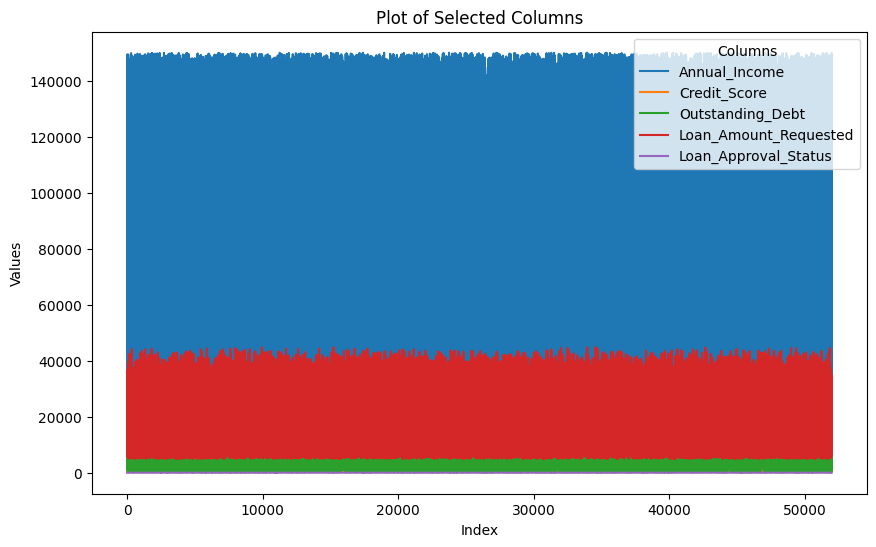

In [180]:
import pandas as pd
import matplotlib.pyplot as plt

columns_to_plot = selected_columns
# Plot the data 
data[columns_to_plot].plot(kind='line', figsize=(10, 6))

# Adding titles and labels using matplotlib (plt)
plt.title('Plot of Selected Columns')  
plt.xlabel('Index') 
plt.ylabel('Values') 

# Adding a legend with a title
plt.legend(title='Columns')

# Show the plot
plt.show()  


c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


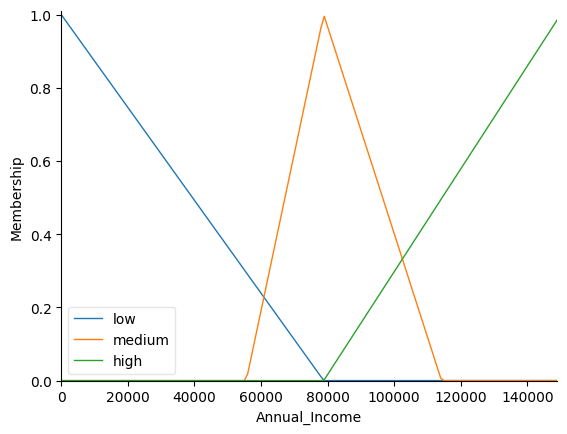

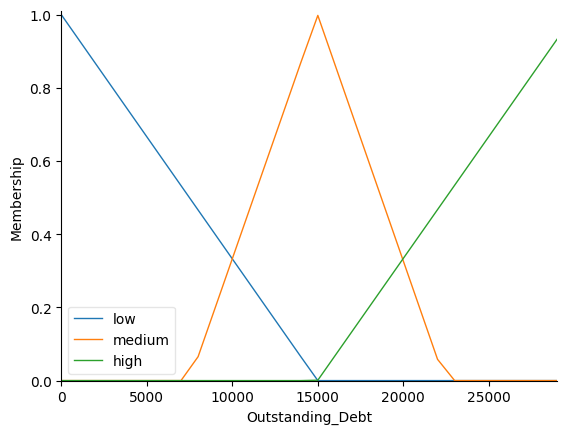

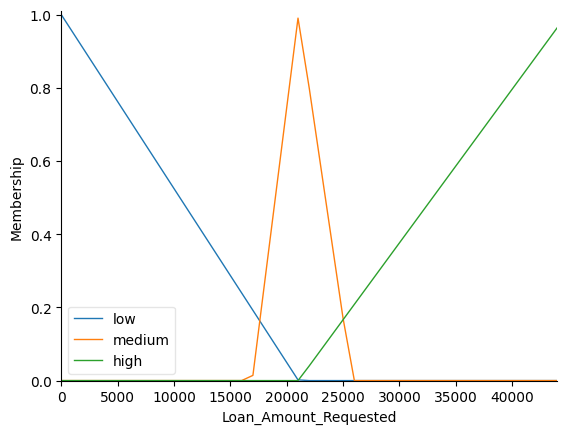

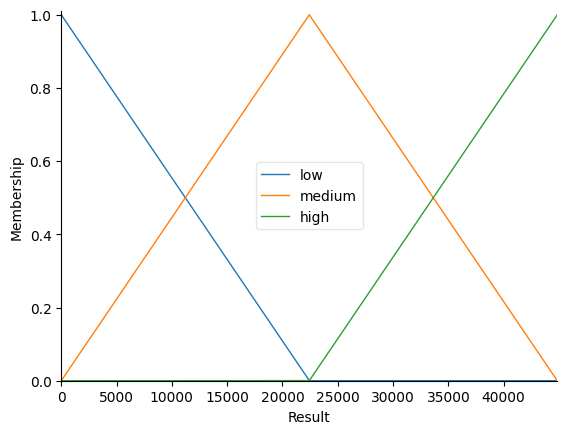

In [261]:
# Calculating the max, min, and average of 'Annual_income' column
max_income = data['Annual_Income'].max()  
max_loan = data['Loan_Amount_Requested'].max()  
max_outstanding_debt = data['Outstanding_Debt'].max()

# Fuzy variable
annual_income = ctrl.Antecedent(np.arange(0, max_income + 1, 1000), 'Annual_Income')
loan_amount_requested = ctrl.Antecedent(np.arange(0, max_loan + 1, 1000), 'Loan_Amount_Requested')
outstanding_debt = ctrl.Antecedent(np.arange(0, max_outstanding_debt + 1, 1000), 'Outstanding_Debt')
result = ctrl.Consequent(np.arange(0, max_loan + 1, 1), 'Result') 


def custom_fuzzification(antecedent, data, column_name):
    """
    Sets up 'low', 'medium', and 'high' fuzzy membership functions for a given column in the data.
    
    Parameters:
    - antecedent: The fuzzy antecedent to apply the memberships to (e.g., annual_income).
    - data: The DataFrame containing the data.
    - column_name: The column name to base the membership functions on.
    """
    # Calculate cutoffs dynamically
    low_cutoff = data[column_name].quantile(0.5)
    medium_cutoff_start = data[column_name].quantile(0.25)
    medium_cutoff_middle = data[column_name].quantile(0.5)
    medium_cutoff_end = data[column_name].quantile(0.75)
    max_value = data[column_name].max()

    # Triangular membership functions
    antecedent['low'] = fuzz.trimf(antecedent.universe, [0, 0, low_cutoff])
    antecedent['medium'] = fuzz.trimf(antecedent.universe, [medium_cutoff_start, medium_cutoff_middle, medium_cutoff_end])
    antecedent['high'] = fuzz.trimf(antecedent.universe, [medium_cutoff_middle, max_value, max_value])

# Custom fuzzification function
custom_fuzzification(annual_income, data, "Annual_Income")
custom_fuzzification(loan_amount_requested, data, "Loan_Amount_Requested")
custom_fuzzification(outstanding_debt, data, "Outstanding_Debt")


# maybe average later or not
result['low'] = fuzz.trimf(result.universe, [0, 0, max_loan/2])
result['medium'] = fuzz.trimf(result.universe, [0, max_loan/2, max_loan])
result['high'] = fuzz.trimf(result.universe, [max_loan/2, max_loan, max_loan])




annual_income.view()
outstanding_debt.view()
loan_amount_requested.view()
result.view()

In [208]:
#Split the dataset into X, and y.
X = data[selected_columns].drop(columns=['Loan_Approval_Status'])

In [207]:
print(X)

       Applicant_ID  Gender  Age Marital_Status  Dependents     Education  \
0                 1  Female   25        Married           2      Graduate   
1                 2    Male   36        Married           2   High School   
2                 3    Male   43         Single           0  Postgraduate   
3                 4  Female   28        Married           0   High School   
4                 5  Female   32         Single           0      Graduate   
...             ...     ...  ...            ...         ...           ...   
51995         51996  Female   47       Divorced           1   High School   
51996         51997    Male   25        Married           3   High School   
51997         51998  Female   48        Married           0   High School   
51998         51999  Female   48       Divorced           1   High School   
51999         52000  Female   38         Single           2   High School   

      Employment_Status Occupation_Type Residential_Status City/Town  ...  

In [211]:
# target_column = 'loan_status'
y = data['Loan_Approval_Status']

In [212]:
print(y)

0        1
1        0
2        0
3        1
4        1
        ..
51995    1
51996    1
51997    0
51998    0
51999    1
Name: Loan_Approval_Status, Length: 52000, dtype: int64


In [216]:
# Split the training data into X_train, X_val, y_train, y_val
# # Split the data into 80% train and 20% 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [217]:
# Display the shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (41600, 7), y_train shape: (41600,)
X_val shape: (10400, 7), y_val shape: (10400,)


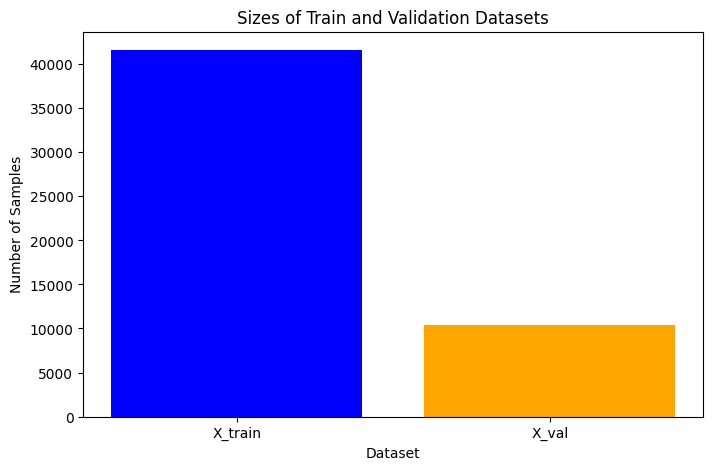

In [218]:
sizes = [X_train.shape[0], X_val.shape[0]]
labels = ['X_train', 'X_val']

# Create a bar plot to visualize the sizes of the datasets
plt.figure(figsize=(8, 5))
plt.bar(labels, sizes, color=['blue', 'orange'])

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Sizes of Train and Validation Datasets')

# Display the plot
plt.show()

In [252]:
# Rule 1: Low income and low debt result in a low loan amount
rule1 = ctrl.Rule(annual_income['low'] & outstanding_debt['low'], result['low'])

# Rule 2: Medium income and low debt result in a medium loan amount
rule2 = ctrl.Rule(annual_income['medium'], result['medium'])

# Rule 3: High income and low debt result in a high loan amount
rule3 = ctrl.Rule(annual_income['high'] & outstanding_debt['low'], result['high'])


In [253]:
# Fuzzy control system
loan_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
loan_decision = ctrl.ControlSystemSimulation(loan_ctrl)

In [289]:
# predict loan approval/rejection
def predict_loan_decision(record_of_data):
    # Pass inputs to the fuzzy system
    annual_income_value = record_of_data['Annual_Income'] 
    outstanding_debt_value = record_of_data['Outstanding_Debt']

    # Compute the fuzzy
    loan_decision.compute()

    # Get loan amount
    loan_amount = loan_decision.output['Result']

    return loan_amount

In [290]:
# For testing we use random single data

In [292]:
record_of_data = data.sample(1)

In [293]:
predicted_loan = predict_loan_decision(record_of_data)


In [294]:
print(predicted_loan)

8494.891145532401


In [ ]:
# For testing we use random multi data

In [295]:
data_sample = data.sample(10)

In [310]:
predicted_loan_amounts = []
for index, record in data_sample.iterrows(): 
    loan_amount = predict_loan_decision(record)  # Assuming predict_loan_decision is already defined
    predicted_loan_amounts.append(loan_amount) 

In [ ]:
# Predict the sample data to get reslts 
predicted_loan_amounts = []
for index, record in data_sample.iterrows():  # Iterating over rows as Series
    loan_amount = predict_loan_decision(record)  # Pass the entire row (Series) to the function
    predicted_loan_amounts.append(loan_amount)

print(predicted_loan_amounts)


[np.float64(8494.891145532401), np.float64(8494.891145532401), np.float64(8494.891145532401), np.float64(8494.891145532401), np.float64(8494.891145532401), np.float64(8494.891145532401), np.float64(8494.891145532401), np.float64(8494.891145532401), np.float64(8494.891145532401), np.float64(8494.891145532401)]


In [312]:
data_sample['Predicted_Loan_Amount'] = predicted_loan_amounts

In [304]:
!pip3 install seaborn

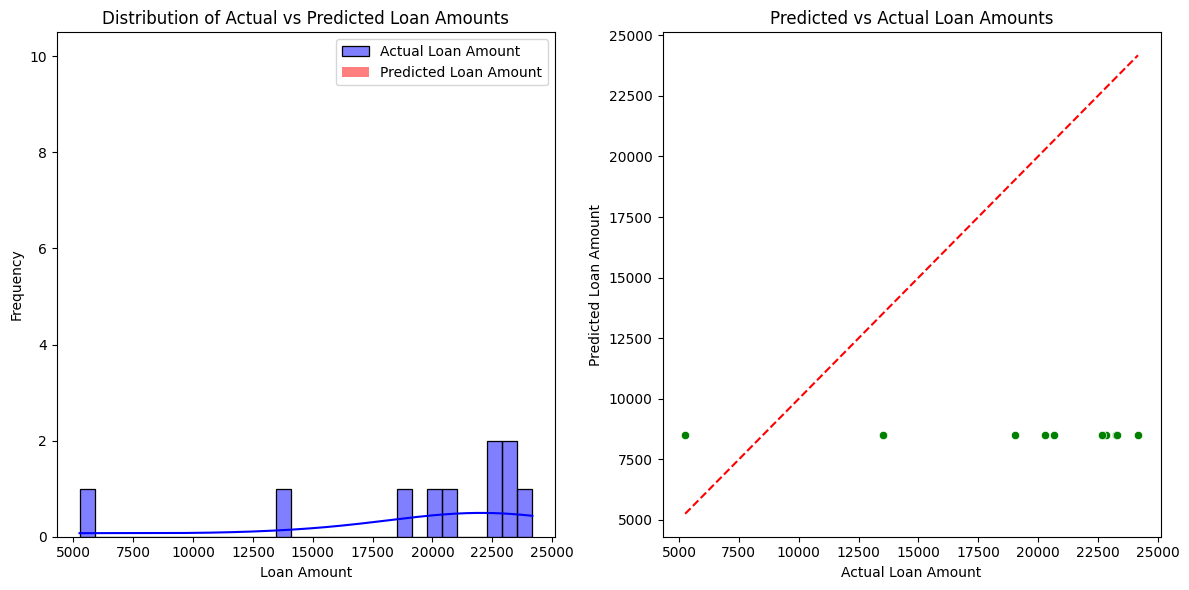

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Plotting Distribution of Actual vs Predicted Loan Amounts
plt.figure(figsize=(12, 6))

# Plot histogram of actual loan amounts vs predicted loan amounts
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
sns.histplot(data_sample['Loan_Amount_Requested'], color='blue', kde=True, label='Actual Loan Amount', bins=30)
sns.histplot(data_sample['Predicted_Loan_Amount'], color='red', kde=True, label='Predicted Loan Amount', bins=30)
plt.legend()
plt.title("Distribution of Actual vs Predicted Loan Amounts")
plt.xlabel("Loan Amount")
plt.ylabel("Frequency")

# Plotting Predicted vs Actual Loan Amounts
plt.subplot(1, 2, 2)  
sns.scatterplot(x=data_sample['Loan_Amount_Requested'], y=data_sample['Predicted_Loan_Amount'], color='green')
plt.plot([data_sample['Loan_Amount_Requested'].min(), data_sample['Loan_Amount_Requested'].max()],
         [data_sample['Loan_Amount_Requested'].min(), data_sample['Loan_Amount_Requested'].max()],
         'r--')  # Plot a line of equality
plt.title("Predicted vs Actual Loan Amounts")
plt.xlabel("Actual Loan Amount")
plt.ylabel("Predicted Loan Amount")

# Display the plots
plt.tight_layout()
plt.show()
